In [1]:
import pickle 
import pandas as pd
import param
import numpy as np
import panel as pn
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import holoviews as hv
import hvplot.pandas
import shap

pn.config.js_files["jquery"]="https://code.jquery.com/jquery-1.12.4.min.js"
pn.config.js_files["sparkline"]="https://cdnjs.cloudflare.com/ajax/libs/jquery-sparklines/2.1.2/jquery.sparkline.min.js"

pn.extension('tabulator', 'plotly', 'ipywidgets', 'perspective',  css_files=[pn.io.resources.CSS_URLS['font-awesome']], sizing_mode='stretch_width', omms='ipywidgets')

pn.config.js_files["sparkline_to_tabulator"]="https://cdn.jsdelivr.net/gh/MarcSkovMadsen/awesome-panel-assets@master/js/add_spark_lines_to_tabulator.min.js"

pn.extension(sizing_mode="stretch_width")


In [2]:
pickle_data = pickle.load(open('Pickle/pvo_expanded2024-01-26.pickle', 'rb'))
pickle_data

,pricing_date,market_maker,market,product,hub,order_type,order_state,market_maker_mnemonic,order_date,oco_order_id,daily_quantity,daily_bo_quantity,order_id,c1_price_basis,c1_price,c1_basis_period,c1_basis_period_details,order_quantity
0,2017-01-10,Shell International Eastern Trading,ASIA FO (PVO),Platts HSFO 380cst,FOB Straits,Offer,withdrawn,SIETCO,2017-01-02,None,5.000000,-5.000000,411167251,MOPS 380,5.0,Full Mnth,Jan,20.0
1,2017-01-11,Shell International Eastern Trading,ASIA FO (PVO),Platts HSFO 380cst,FOB Straits,Offer,withdrawn,SIETCO,2017-01-02,None,5.000000,-5.000000,411167251,MOPS 380,5.0,Full Mnth,Jan,20.0
2,2017-01-12,Shell International Eastern Trading,ASIA FO (PVO),Platts HSFO 380cst,FOB Straits,Offer,withdrawn,SIETCO,2017-01-02,None,5.000000,-5.000000,411167251,MOPS 380,5.0,Full Mnth,Jan,20.0
3,2017-01-13,Shell International Eastern Trading,ASIA FO (PVO),Platts HSFO 380cst,FOB Straits,Offer,withdrawn,SIETCO,2017-01-02,None,5.000000,-5.000000,411167251,MOPS 380,5.0,Full Mnth,Jan,20.0
4,2017-01-11,Shell International Eastern Trading,ASIA FO (PVO),Platts HSFO 380cst,FOB Straits,Offer,withdrawn,SIETCO,2017-01-02,None,6.666667,-6.666667,601313983,MOPS 380,3.0,5,Day,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,2024-02-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-01-26,NaN,2.222222,-2.222222,981200463,NaN,NaN,NaN,NaN,NaN
228,2024-02-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-01-26,NaN,2.222222,-2.222222,981200463,NaN,NaN,NaN,NaN,NaN
229,2024-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-01-26,NaN,2.222222,-2.222222,981200463,NaN,NaN,NaN,NaN,NaN
230,2024-02-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-01-26,NaN,1.666667,1.666667,828891056,NaN,NaN,NaN,NaN,NaN


In [3]:
pickle_data.pricing_date = pd.to_datetime(pickle_data.pricing_date)
pickle_data.order_date = pd.to_datetime(pickle_data.order_date)

dates_diff = pickle_data.pricing_date - pickle_data.order_date
dates_diff

0      8 days
1      9 days
2     10 days
3     11 days
4      9 days
        ...  
227   28 days
228   27 days
229   26 days
230   19 days
231   26 days
Length: 64035, dtype: timedelta64[ns]

In [12]:
unique_dates = pickle_data.order_date.unique()
unique_dates.min(), unique_dates.max()

(numpy.datetime64('2017-01-02T00:00:00.000000000'),
 numpy.datetime64('2024-01-26T00:00:00.000000000'))

In [13]:
main_df = pd.DataFrame()
main_df['order_date'] = unique_dates

main_df

,order_date
0,2017-01-02
1,2017-01-03
2,2017-01-04
3,2017-01-05
4,2017-01-06
...,...
1772,2024-01-22
1773,2024-01-23
1774,2024-01-24
1775,2024-01-25


In [20]:
pickle_data.order_date.value_counts()

2023-12-04    212
2024-01-24    170
2023-12-01    164
2023-12-13    156
2023-12-12    156
             ... 
2017-02-04      5
2019-05-25      4
2019-01-12      4
2019-08-17      3
2021-12-27      3
Name: order_date, Length: 1777, dtype: int64

In [27]:
sorted(pickle_data[pickle_data['order_date'] == '2023-12-04'].pricing_date.unique())

[numpy.datetime64('2023-12-19T00:00:00.000000000'),
 numpy.datetime64('2023-12-20T00:00:00.000000000'),
 numpy.datetime64('2023-12-21T00:00:00.000000000'),
 numpy.datetime64('2023-12-22T00:00:00.000000000'),
 numpy.datetime64('2023-12-25T00:00:00.000000000'),
 numpy.datetime64('2023-12-26T00:00:00.000000000'),
 numpy.datetime64('2023-12-27T00:00:00.000000000'),
 numpy.datetime64('2023-12-28T00:00:00.000000000'),
 numpy.datetime64('2023-12-29T00:00:00.000000000'),
 numpy.datetime64('2024-01-01T00:00:00.000000000'),
 numpy.datetime64('2024-01-02T00:00:00.000000000'),
 numpy.datetime64('2024-01-03T00:00:00.000000000')]

In [14]:
def transform_date(date):
    return str(date)[:10]

def get_pricing_dates(date):
    temp = pickle_data[pickle_data.order_date == date]['pricing_date']
    d1, d2 = transform_date(temp.pricing_date.min()), transform_date(temp.pricing_date.max())
    
    return f'{d1} to {d2}'


# main_df['pricing_date'] = get_pricing_dates(pickle_data, )

If we have 212 values for order_date (the max count for 2023-12-04) and 12 unique pricing_date values, how do we get different target values?

How to combine them together to plot everything together as in the picture?

# Easier option with pricing_date and companies 

In [41]:
pickle_data[['pricing_date', 'daily_bo_quantity']].drop_duplicates().groupby('pricing_date').count().sort_values('daily_bo_quantity', ascending=False)

,daily_bo_quantity
pricing_date,
2024-01-09,24
2024-01-08,24
2024-01-10,24
2024-01-11,24
2024-01-04,23
...,...
2017-01-18,4
2017-01-11,2
2017-01-13,2


<Axes: xlabel='order_date', ylabel='daily_bo_quantity'>

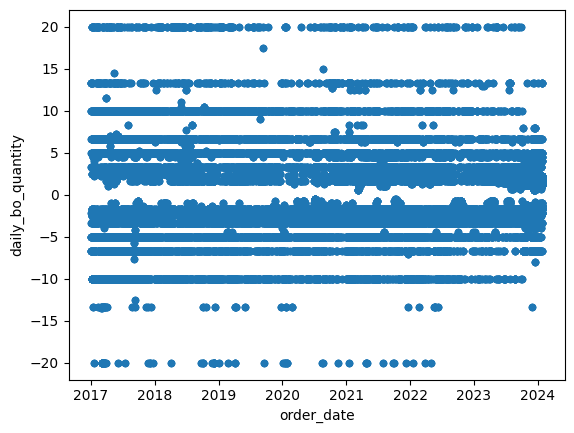

In [46]:
to_plot = pickle_data[['order_date', 'daily_bo_quantity']]
to_plot.plot(x='order_date', y='daily_bo_quantity', kind='scatter')

In [48]:
pd.read_csv('data/data_2024-01-26.csv')

,pricing_date,ALVARI,ARAMCOSG,ARAMCOTF,ARCENERGY,BBEN,BPSG,BRIGHTOILSG,BUYER1,BUYER2,...,_rgp_03_sz_3,_rgp_04_sz_3,_rgp_05_sz_3,_rgp_06_sz_3,_rgp_07_sz_3,_rgp_08_sz_3,_rgp_09_sz_3,_rgp_10_sz_3,_rgp_11_sz_3,F380 M2/M3
0,2017-01-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.50
1,2017-01-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.30
2,2017-01-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,530.0,0.000000,920.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.70
3,2017-01-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1060.0,0.000000,615.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.85
4,2017-01-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1060.0,0.000000,3.333333,0.0,0.0,0.0,0.000000,0.0,0.0,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1854,2024-02-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,156.666667,0.000000,0.0,0.0,0.0,232.888889,0.0,0.0,NaN
1855,2024-02-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,156.666667,0.000000,0.0,0.0,0.0,219.000000,0.0,0.0,NaN
1856,2024-02-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,90.000000,0.000000,0.0,0.0,0.0,219.000000,0.0,0.0,NaN
1857,2024-02-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,90.000000,0.000000,0.0,0.0,0.0,152.333333,0.0,0.0,NaN


In [2]:
data = pickle.load(open('Pickle/last_order2024-01-26.pickle', 'rb'))[['order_date', 'market_maker_mnemonic', 'bo_quantity']].drop_duplicates()
data

,order_date,market_maker_mnemonic,bo_quantity
0,2017-01-02,SIETCO,-20
5,2017-01-03,VITOLSG,-20
6,2017-01-03,BPSG,40
7,2017-01-03,LUKOIL,-20
8,2017-01-03,SIETCO,-20
...,...,...,...
50,2024-01-26,GLENCORESG,40
52,2024-01-26,SIETCO,-20
56,2024-01-26,REXCOMM,20
57,2024-01-26,PETROCHINA,20


In [3]:
data = data.pivot_table(index='order_date', columns='market_maker_mnemonic', values='bo_quantity')
data.fillna(0, inplace=True)
data

market_maker_mnemonic,ALVARI,ARAMCOSG,ARAMCOTF,ARCENERGY,BBEN,BPSG,BRIGHTOILSG,BUYER1,BUYER2,CAOSG,...,SINOPECHKSG,SKEISG,SOCAR,SUMMITENERGY,TOTALSG,TRAFI,UNIPECSG,VITOLSG,WANXIANG,ZENROCK
order_date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-03,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0
2017-01-04,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0
2017-01-05,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0
2017-01-06,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,40.0,-20.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-20.0,0.0,20.0,0.0,0.0
2024-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-20.0,0.0,20.0,0.0,0.0
2024-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-20.0,0.0,20.0,0.0,0.0


In [4]:
data.columns.name = ''
data

,ALVARI,ARAMCOSG,ARAMCOTF,ARCENERGY,BBEN,BPSG,BRIGHTOILSG,BUYER1,BUYER2,CAOSG,...,SINOPECHKSG,SKEISG,SOCAR,SUMMITENERGY,TOTALSG,TRAFI,UNIPECSG,VITOLSG,WANXIANG,ZENROCK
order_date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-03,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0
2017-01-04,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0
2017-01-05,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0
2017-01-06,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,40.0,-20.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-20.0,0.0,20.0,0.0,0.0
2024-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-20.0,0.0,20.0,0.0,0.0
2024-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-20.0,0.0,20.0,0.0,0.0


In [5]:
data.index = pd.to_datetime(data.index)

In [7]:
# !pip install jupyter_bokeh==2.0.0

# pn.extension(comms='vscode')

date_values = (data.index.min().date(), data.index.max().date())

date_range_slider = pn.widgets.DatetimeRangePicker(name='Datetime Range Picker', value=date_values)

date_range_slider

ModuleNotFoundError: No module named 'jupyter_bokeh'

DatetimeRangePicker(as_numpy_datetime64=False, name='Datetime Range Picker', sizing_mode='stretch_width', value=(datetime.date(2017, ...)

In [14]:
excel_df = pd.read_excel('gpt_lo_expanded.xlsx', index_col=0)
excel_df = excel_df.pivot_table(index=['pricing_date', 'order_date'], columns='market_maker_mnemonic', values='daily_quantity').fillna(0)
excel_df.reset_index(inplace=True)
excel_df.set_index('pricing_date', inplace=True)

In [25]:
start, end = '2024-01-12', '2024-12-31'

excel_df[(excel_df.order_date) > start]

market_maker_mnemonic,order_date,BPSG,GUNVORSG,MIPCO,PETROCHINA,REXCOMM,SIETCO,SINOPECFO,TOTALSG,TRAFI,VITOLSG
pricing_date,,,,,,,,,,,
2024-01-30,2024-01-15,0.000000,1.428571,1.666667,0.000000,0.000000,1.250000,1.666667,0.0,1.666667,0.000000
2024-01-31,2024-01-15,0.000000,1.428571,1.666667,2.222222,6.666667,1.250000,1.666667,0.0,1.666667,0.000000
2024-01-31,2024-01-16,2.222222,0.000000,2.222222,0.000000,0.000000,2.222222,2.222222,0.0,2.222222,0.000000
2024-02-01,2024-01-15,3.333333,1.428571,1.666667,2.222222,6.666667,1.250000,1.666667,0.0,1.666667,0.000000
2024-02-01,2024-01-16,2.222222,0.000000,2.222222,2.222222,2.222222,2.222222,2.222222,0.0,2.222222,0.000000
2024-02-01,2024-01-17,2.222222,1.904762,0.000000,0.000000,0.000000,1.666667,2.222222,0.0,0.000000,0.000000
2024-02-02,2024-01-15,3.333333,1.428571,1.666667,2.222222,6.666667,1.458333,1.666667,0.0,1.666667,0.000000
2024-02-02,2024-01-16,2.777778,0.000000,2.222222,2.222222,2.222222,2.222222,2.222222,0.0,2.222222,0.000000
2024-02-02,2024-01-17,2.222222,1.904762,0.000000,2.222222,2.222222,1.666667,2.222222,0.0,0.000000,0.000000


In [ ]:
price_date = order_end + pricing_date #call back value
order_start = order_end - order_start # call back value 

fltr_order_date = df.order_date >= order_start & df.order_date <= order_end
fltr_price_date = df.price_date<= price_date

In [19]:
import plotly.express as px

fltr = excel_df.order_date > '2024-01-16'
plot_df = excel_df[fltr].drop(columns='order_date')

px.bar(plot_df)

In [20]:
fltr = excel_df.order_date > '2024-01-15'
plot_df = excel_df[fltr].drop(columns='order_date')

px.bar(plot_df)

In [24]:
from datetime import date

excel_df.order_date = pd.to_datetime(excel_df.order_date)

date.fromisoformat(str(excel_df.order_date.min())[:10])

datetime.date(2024, 1, 9)

In [26]:
pickle.load(open('Pickle/lo_vol_expanded.pickle', 'rb'))

,pricing_date,order_date,daily_quantity,daily_bo_quantity,order_id
0,2017-01-13,2017-01-02,5.000000,-5.000000,411167251
1,2017-01-11,2017-01-02,6.666667,-6.666667,601313983
2,2017-01-12,2017-01-02,6.666667,-6.666667,601313983
3,2017-01-13,2017-01-02,6.666667,-6.666667,601313983
4,2017-01-13,2017-01-02,3.333333,-3.333333,393261878
...,...,...,...,...,...
210589,2024-02-12,2024-01-26,1.666667,1.666667,828891056
210590,2024-02-22,2024-01-26,5.000000,5.000000,288870090
210591,2024-02-21,2024-01-26,5.000000,5.000000,288870090
210592,2024-02-19,2024-01-26,5.000000,5.000000,288870090


In [28]:
data.columns

Index(['ALVARI', 'ARAMCOSG', 'ARAMCOTF', 'ARCENERGY', 'BBEN', 'BPSG',
       'BRIGHTOILSG', 'BUYER1', 'BUYER2', 'CAOSG', 'CARGILLSG', 'CCMA',
       'CHEVRONSG', 'COASTAL', 'ENEOSSG', 'ENOC', 'FREEPTSG', 'GLENCORESG',
       'GPGLOBALSG', 'GULFSG', 'GUNVORSG', 'HL', 'IDEMITSU', 'ITGRES',
       'KAIROS', 'KOCHRI', 'LUKOIL', 'MACQUARIESG', 'MAERSKSG',
       'MERCURIARESOURCES', 'MERCURIASG', 'METS', 'MIPCO', 'P66SG', 'PETCO',
       'PETROCHINA', 'PETROSUMMIT', 'PTT', 'REPSOLSG', 'REXCOMM', 'RGES',
       'SELLER1', 'SIETCO', 'SINOHKPET', 'SINOPECFO', 'SINOPECHKSG', 'SKEISG',
       'SOCAR', 'SUMMITENERGY', 'TOTALSG', 'TRAFI', 'UNIPECSG', 'VITOLSG',
       'WANXIANG', 'ZENROCK'],
      dtype='object', name='')

In [35]:
import plotly.express as px

def create_color_dict(columns):
    # Predefined set of colors
    colors = px.colors.qualitative.Alphabet

    # Create a unique color dictionary for the given columns
    color_dict = {column: colors[i % len(colors)] for i, column in enumerate(columns)}

    return color_dict

# Example usage
columns_to_color = ['ALVARI', 'ARAMCOSG', 'ARAMCOTF', 'ARCENERGY', 'BBEN', 'BPSG',
                    'BRIGHTOILSG', 'BUYER1', 'BUYER2', 'CAOSG', 'CARGILLSG', 'CCMA',
                    'CHEVRONSG', 'COASTAL', 'ENEOSSG', 'ENOC', 'FREEPTSG', 'GLENCORESG',
                    'GPGLOBALSG', 'GULFSG', 'GUNVORSG', 'HL', 'IDEMITSU', 'ITGRES',
                    'KAIROS', 'KOCHRI', 'LUKOIL', 'MACQUARIESG', 'MAERSKSG',
                    'MERCURIARESOURCES', 'MERCURIASG', 'METS', 'MIPCO', 'P66SG', 'PETCO',
                    'PETROCHINA', 'PETROSUMMIT', 'PTT', 'REPSOLSG', 'REXCOMM', 'RGES',
                    'SELLER1', 'SIETCO', 'SINOHKPET', 'SINOPECFO', 'SINOPECHKSG', 'SKEISG',
                    'SOCAR', 'SUMMITENERGY', 'TOTALSG', 'TRAFI', 'UNIPECSG', 'VITOLSG',
                    'WANXIANG', 'ZENROCK']

color_dict = create_color_dict(columns_to_color)

# Print the generated color dictionary
print(color_dict)

{'ALVARI': '#AA0DFE', 'ARAMCOSG': '#3283FE', 'ARAMCOTF': '#85660D', 'ARCENERGY': '#782AB6', 'BBEN': '#565656', 'BPSG': '#1C8356', 'BRIGHTOILSG': '#16FF32', 'BUYER1': '#F7E1A0', 'BUYER2': '#E2E2E2', 'CAOSG': '#1CBE4F', 'CARGILLSG': '#C4451C', 'CCMA': '#DEA0FD', 'CHEVRONSG': '#FE00FA', 'COASTAL': '#325A9B', 'ENEOSSG': '#FEAF16', 'ENOC': '#F8A19F', 'FREEPTSG': '#90AD1C', 'GLENCORESG': '#F6222E', 'GPGLOBALSG': '#1CFFCE', 'GULFSG': '#2ED9FF', 'GUNVORSG': '#B10DA1', 'HL': '#C075A6', 'IDEMITSU': '#FC1CBF', 'ITGRES': '#B00068', 'KAIROS': '#FBE426', 'KOCHRI': '#FA0087', 'LUKOIL': '#AA0DFE', 'MACQUARIESG': '#3283FE', 'MAERSKSG': '#85660D', 'MERCURIARESOURCES': '#782AB6', 'MERCURIASG': '#565656', 'METS': '#1C8356', 'MIPCO': '#16FF32', 'P66SG': '#F7E1A0', 'PETCO': '#E2E2E2', 'PETROCHINA': '#1CBE4F', 'PETROSUMMIT': '#C4451C', 'PTT': '#DEA0FD', 'REPSOLSG': '#FE00FA', 'REXCOMM': '#325A9B', 'RGES': '#FEAF16', 'SELLER1': '#F8A19F', 'SIETCO': '#90AD1C', 'SINOHKPET': '#F6222E', 'SINOPECFO': '#1CFFCE', 'S

In [31]:
excel_df[excel_df.order_date == '2024-01-09']

market_maker_mnemonic,order_date,BPSG,GUNVORSG,MIPCO,PETROCHINA,REXCOMM,SIETCO,SINOPECFO,TOTALSG,TRAFI,VITOLSG
pricing_date,,,,,,,,,,,
2024-01-24,2024-01-09,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,6.666667,0.000000,0.0
2024-01-25,2024-01-09,6.666667,0.0,0.0,0.0,0.0,0.000000,0.0,6.666667,0.000000,0.0
2024-01-26,2024-01-09,6.666667,0.0,0.0,0.0,0.0,0.000000,0.0,6.666667,0.000000,0.0
2024-01-29,2024-01-09,6.666667,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.333333,0.0
2024-01-30,2024-01-09,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.333333,0.0
2024-01-31,2024-01-09,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.333333,0.0
2024-02-01,2024-01-09,0.000000,0.0,0.0,0.0,0.0,3.333333,0.0,0.000000,1.333333,0.0
2024-02-02,2024-01-09,0.000000,0.0,0.0,0.0,0.0,3.333333,0.0,0.000000,1.333333,0.0
2024-02-05,2024-01-09,0.000000,0.0,0.0,0.0,0.0,3.333333,0.0,0.000000,2.222222,0.0


In [40]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Create subplot with two stacked bar charts
fig = make_subplots(rows=1, cols=1)

fig1 = px.bar(excel_df[excel_df.order_date == '2024-01-09'].drop(columns='order_date'), color_discrete_map=color_dict, text_auto=True)

for trace in fig1.data:
    fig.add_trace(trace)

fig.update_layout(barmode='stack')
fig.show()


In [41]:
def get_lo_vol_expanded(last_order):
    expand_pvo_order = pd.DataFrame()

    for index, r in last_order.iterrows():
        # only expand phyiscal order
        if r.market_type == 'Platts Variable Oil':
            expand_order = pd.DataFrame()
            order_begin = r.order_begin
            order_end = r.order_end

            oco_order_no = 0
            # This line help to expand the order
            # create date first then fill the order_id otherwise order_id will be NaN
            expand_order['pricing_date'] = pd.bdate_range(start=order_begin, end=order_end, freq="B")
            expand_order['order_date'] = r.order_date
            expand_order['daily_quantity'] = r.daily_quantity
            expand_order['daily_bo_quantity'] = r.daily_bo_quantity
            expand_order['order_id'] = r.order_id

            expand_pvo_order = pd.concat([expand_order, expand_pvo_order], ignore_index=True)

            # end of loop
    return expand_pvo_order




In [42]:
last_order = pickle.load(open('Pickle/last_order2024-01-26.pickle', 'rb'))
lo_vol = get_lo_vol_expanded(last_order)

In [43]:
order_id_market_maker = last_order[['order_id','market_maker_mnemonic']]
lo_mm_expanded = pd.merge(lo_vol, order_id_market_maker,'outer', left_on='order_id', right_on='order_id')
lo_mm_expanded.head(1000)

,pricing_date,order_date,daily_quantity,daily_bo_quantity,order_id,market_maker_mnemonic
0,2024-02-21,2024-01-26,4.444444,4.444444,180017046,GUNVORSG
1,2024-02-22,2024-01-26,4.444444,4.444444,180017046,GUNVORSG
2,2024-02-23,2024-01-26,4.444444,4.444444,180017046,GUNVORSG
3,2024-02-16,2024-01-26,2.222222,-2.222222,791857968,TRAFI
4,2024-02-19,2024-01-26,2.222222,-2.222222,791857968,TRAFI
...,...,...,...,...,...,...
995,2024-02-14,2024-01-16,2.222222,-2.222222,660108532,MIPCO
996,2024-02-12,2024-01-16,2.222222,-2.222222,660108532,MIPCO
997,2024-02-12,2024-01-16,2.222222,-2.222222,660108532,MIPCO
998,2024-02-13,2024-01-16,2.222222,-2.222222,660108532,MIPCO


In [45]:
lo_mm_expanded.to_excel('huge_excel.xlsx')